# Gradient descent way

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from time import time


In [5]:

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# One-hot encode the target labels
y = to_categorical(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training time: 2.25 seconds
Test accuracy: 1.00


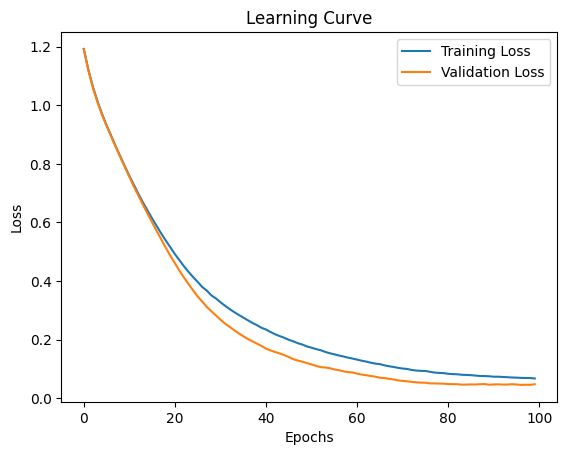

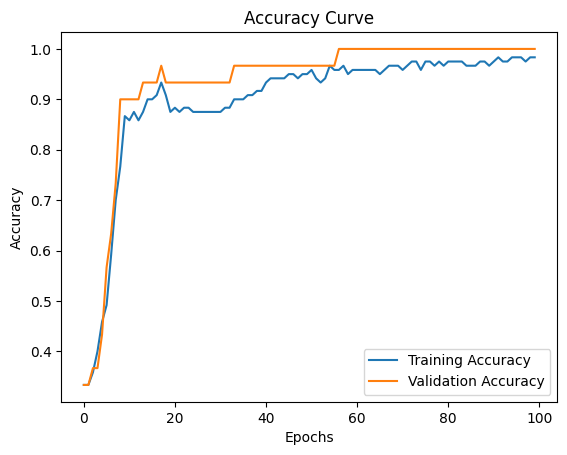

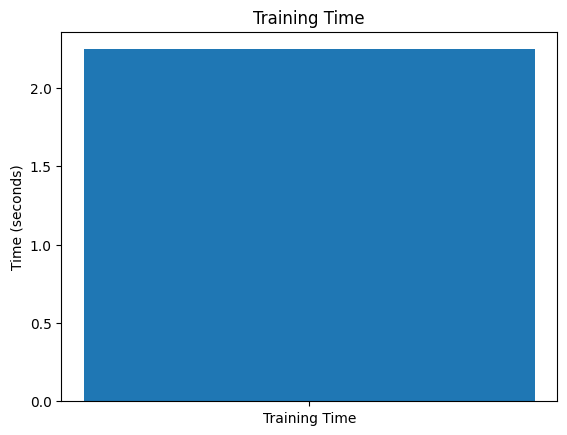

In [6]:

# Define the neural network model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and record the training time
start_time = time()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10, verbose=0)
end_time = time()
training_time = end_time - start_time

# Print training time
print(f"Training time: {training_time:.2f} seconds")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.2f}")

# Generate learning curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Generate accuracy curve
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Plot training time
plt.figure()
plt.bar(['Training Time'], [training_time])
plt.ylabel('Time (seconds)')
plt.title('Training Time')
plt.show()


# RO way

In [11]:
import mlrose_hiive as mlrose
from sklearn.model_selection import KFold, train_test_split
from nn_fitness import CustomFitness

In [12]:
# Define the neural network model
def build_model(weights):
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    
    # Set the weights to the model
    start = 0
    for layer in model.layers:
        end = start + np.prod(layer.get_weights()[0].shape)
        new_weights = weights[start:end].reshape(layer.get_weights()[0].shape)
        start = end
        end = start + np.prod(layer.get_weights()[1].shape)
        new_biases = weights[start:end].reshape(layer.get_weights()[1].shape)
        start = end
        layer.set_weights([new_weights, new_biases])
    
    return model

In [27]:
# # Define the custom fitness function class
# class CustomFitness:
#     def __init__(self, X_train, y_train, input_dim, output_dim):
#         self.X_train = X_train
#         self.y_train = y_train
#         self.input_dim = input_dim
#         self.output_dim = output_dim

#     def __call__(self, weights):
#         return self.fitness_function(weights)

#     def fitness_function(self, weights):
#         model = build_model(weights, self.input_dim, self.output_dim)
#         model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#         loss, accuracy = model.evaluate(self.X_train, self.y_train, verbose=0)
#         return -loss  # Multiply the loss by -1 to make it a maximization problem
    
#     def get_prob_type(self):
#         return 'continuous'



In [25]:
# Define the problem dimensions
input_dim = X.shape[1]
output_dim = y.shape[1]
model_example = Sequential([
    Dense(10, input_dim=input_dim, activation='relu'),
    Dense(10, activation='relu'),
    Dense(output_dim, activation='softmax')
])
total_weights = sum(np.prod(layer.get_weights()[0].shape) + np.prod(layer.get_weights()[1].shape) for layer in model_example.layers)


In [28]:

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results containers
results = {"RHC": [], "SA": [], "GA": []}
histories = {"RHC": [], "SA": [], "GA": []}
training_times = {"RHC": [], "SA": [], "GA": []}
test_accuracies = {"RHC": [], "SA": [], "GA": []}

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the custom fitness function instance
    fitness = Fitness(X_train, y_train, input_dim, output_dim)

    # Define the optimization problem
    problem = mlrose.ContinuousOpt(length=total_weights, fitness_fn=fitness, maximize=True)

    # Random Hill Climbing
    start_time = time()
    best_state_rhc, best_fitness_rhc, fitness_curve_rhc = mlrose.random_hill_climb(problem, max_attempts=100, max_iters=1000, curve=True, random_state=42)
    training_times["RHC"].append(time() - start_time)
    results["RHC"].append(best_fitness_rhc)
    histories["RHC"].append(fitness_curve_rhc)

    # Simulated Annealing
    start_time = time()
    best_state_sa, best_fitness_sa, fitness_curve_sa = mlrose.simulated_annealing(problem, max_attempts=100, max_iters=1000, curve=True, random_state=42)
    training_times["SA"].append(time() - start_time)
    results["SA"].append(best_fitness_sa)
    histories["SA"].append(fitness_curve_sa)

    # Genetic Algorithm
    start_time = time()
    best_state_ga, best_fitness_ga, fitness_curve_ga = mlrose.genetic_alg(problem, max_attempts=100, max_iters=1000, curve=True, random_state=42, pop_size=300, mutation_prob=0.2)
    training_times["GA"].append(time() - start_time)
    results["GA"].append(best_fitness_ga)
    histories["GA"].append(fitness_curve_ga)

    # Evaluate the optimized models on the test set
    for algo, best_state in zip(["RHC", "SA", "GA"], [best_state_rhc, best_state_sa, best_state_ga]):
        model = build_model(best_state, input_dim, output_dim)
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        test_accuracies[algo].append(accuracy)

# Calculate mean results across folds
mean_test_accuracies = {algo: np.mean(test_accuracies[algo]) for algo in ["RHC", "SA", "GA"]}
mean_training_times = {algo: np.mean(training_times[algo]) for algo in ["RHC", "SA", "GA"]}
mean_results = {algo: np.mean(results[algo]) for algo in ["RHC", "SA", "GA"]}
mean_histories = {algo: np.mean(histories[algo], axis=0) for algo in ["RHC", "SA", "GA"]}

# Print mean test accuracies
for algo in ["RHC", "SA", "GA"]:
    print(f"Mean test accuracy for {algo}: {mean_test_accuracies[algo]:.2f}")

# Plot Fitness vs Iteration
plt.figure()
for algo in mean_histories:
    plt.plot(mean_histories[algo], label=algo)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness vs Iteration (Cross-Validation)')
plt.legend()
plt.show()

# Plot Fitness vs Algorithm
plt.figure()
plt.bar(["RHC", "SA", "GA"], [mean_results[algo] for algo in ["RHC", "SA", "GA"]])
plt.xlabel('Algorithm')
plt.ylabel('Best Fitness')
plt.title('Best Fitness (Cross-Validation)')
plt.show()

# Plot Function Evaluations vs Algorithm
# Since we use max_iters as 1000 for each algorithm, function evaluations would be equivalent
function_evals = [1000, 1000, 1000]
plt.figure()
plt.bar(["RHC", "SA", "GA"], function_evals)
plt.xlabel('Algorithm')
plt.ylabel('Function Evaluations')
plt.title('Function Evaluations (Cross-Validation)')
plt.show()

# Plot Wall Clock Time vs Algorithm
plt.figure()
plt.bar(["RHC", "SA", "GA"], [mean_training_times[algo] for algo in ["RHC", "SA", "GA"]])
plt.xlabel('Algorithm')
plt.ylabel('Wall Clock Time (s)')
plt.title('Wall Clock Time (Cross-Validation)')
plt.show()

AttributeError: 'CustomFitness' object has no attribute 'evaluate'